# Linear Models and Regularisation
### In this notebook we analyse various approaches to improve the predictive power of linear models on new (test) samples, i.e., decreasing the variance in the fitted models.
## 1. Subset Selection Methods
### When performing subset selection, the goal is to determine which combination of predictors actually are associated with the response, so that we only include them in the model thereby removing unwanted variance.
### 1.1 Best Subset Selection
### Best subset selection involves fitting all $2^p$ models, where $p$ is the total number of predictors. For each subset of models with a given number of predictors, the "best" model is determined by comparing the RSS (note that we cannot use this statistic across models with different numbers of predictors since the RSS always decreases as more variables are added to the model). Instead, to determine the overall best model, we should use the adjusted $R^2$, $C_p$ or $BIC$ statistics.

In [190]:
# import relevant libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd 
import math
import random
import itertools
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.regressionplots import *
from sklearn.pipeline import make_pipeline
from sklearn import datasets, linear_model
from sklearn.decomposition import PCA 
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.preprocessing import StandardScaler, scale 
from sklearn import linear_model 
from sklearn.model_selection import cross_val_predict 
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV

In [2]:
# import the data set for this task
Hitters = pd.read_csv("Hitters.csv", header=0, na_values='NA')
print("Columns in data set:", list(Hitters))
print("Shape:", Hitters.shape)
print("First 5 entries:\n", Hitters.head())

Columns in data set: ['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat', 'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'League', 'Division', 'PutOuts', 'Assists', 'Errors', 'Salary', 'NewLeague']
Shape: (322, 20)
First 5 entries:
    AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  CHits  CHmRun  CRuns  \
0    293    66      1    30   29     14      1     293     66       1     30   
1    315    81      7    24   38     39     14    3449    835      69    321   
2    479   130     18    66   72     76      3    1624    457      63    224   
3    496   141     20    65   78     37     11    5628   1575     225    828   
4    321    87     10    39   42     30      2     396    101      12     48   

   CRBI  CWalks League Division  PutOuts  Assists  Errors  Salary NewLeague  
0    29      14      A        E      446       33      20     NaN         A  
1   414     375      N        W      632       43      10   475.0         N  
2   266     263      A        W     

### The data set we are analysing contains information about various baseball players and their performance throughout the previous season. We shall use this to predict the 'Salary' variable for the upcoming season. Unfortunately, some of the entries have missing 'Salary' information, so we should remove them first before fitting a model.

In [3]:
print("Number of entries with missing Salary information:", Hitters['Salary'].isnull().sum())

Hitters = Hitters.dropna().reset_index(drop=True)
print("Number of entries with missing Salary information after clean-up:", Hitters['Salary'].isnull().sum())
print("Shape of data set after clean-up:", Hitters.shape)

Number of entries with missing Salary information: 59
Number of entries with missing Salary information after clean-up: 0
Shape of data set after clean-up: (263, 20)


### Note also that some of the predictors are categorical in the data set - 'League', 'Division', and 'NewLeague'. We shall replace these with dummy variables before fitting any model.

In [4]:
y_data = Hitters.Salary
dummy_predictors = pd.get_dummies(Hitters[['League', 'Division', 'NewLeague']])
print(dummy_predictors.head())

   League_A  League_N  Division_E  Division_W  NewLeague_A  NewLeague_N
0         0         1           0           1            0            1
1         1         0           0           1            1            0
2         0         1           1           0            0            1
3         0         1           1           0            0            1
4         1         0           0           1            1            0


In [5]:
X = pd.concat([Hitters.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64'), dummy_predictors[['League_A', 'Division_E', 'NewLeague_A']]], axis=1)
print(X.head())
print(X.shape)

   AtBat   Hits  HmRun  Runs   RBI  Walks  Years  CAtBat   CHits  CHmRun  \
0  315.0   81.0    7.0  24.0  38.0   39.0   14.0  3449.0   835.0    69.0   
1  479.0  130.0   18.0  66.0  72.0   76.0    3.0  1624.0   457.0    63.0   
2  496.0  141.0   20.0  65.0  78.0   37.0   11.0  5628.0  1575.0   225.0   
3  321.0   87.0   10.0  39.0  42.0   30.0    2.0   396.0   101.0    12.0   
4  594.0  169.0    4.0  74.0  51.0   35.0   11.0  4408.0  1133.0    19.0   

   CRuns   CRBI  CWalks  PutOuts  Assists  Errors  League_A  Division_E  \
0  321.0  414.0   375.0    632.0     43.0    10.0         0           0   
1  224.0  266.0   263.0    880.0     82.0    14.0         1           0   
2  828.0  838.0   354.0    200.0     11.0     3.0         0           1   
3   48.0   46.0    33.0    805.0     40.0     4.0         0           1   
4  501.0  336.0   194.0    282.0    421.0    25.0         1           0   

   NewLeague_A  
0            0  
1            1  
2            0  
3            0  
4      

In [6]:
# define function for performing best subset selection
def getRSS(y, X, feature_list):
    """
    Fit a model for a given subset of features in X, determined by feature_list, and record the RSS on the training data.
    """
    model = sm.OLS(y, sm.add_constant(X[list(feature_list)])).fit()
    RSS = ((model.predict(sm.add_constant(X[list(feature_list)])) - y)**2).sum()
    return {'Model': model, "RSS": RSS}

def bestModel(y, X, K):
    """
    Finds the best model with K predictors.
    """
    all_models = []
    for c in itertools.combinations(X.columns, K):
        all_models.append(getRSS(y, X, c))
    all_models = pd.DataFrame(all_models)

    best_model = all_models.loc[all_models["RSS"].idxmin()]
    return best_model

In [7]:
max_feature_count = X.shape[1]
models = pd.DataFrame(columns=['RSS', 'Model'])

In [18]:
max_feature_count = 13
for no_features in range(1, max_feature_count + 1):
    if no_features in models.index:
        continue
    print("Finding best model for " + str(no_features) + "/19 features...")
    models.loc[no_features] = bestModel(y_data, X, no_features)
    print("Best model found with R^2:", models.loc[no_features].Model.rsquared)
    print("and adjusted R^2:", models.loc[no_features].Model.rsquared_adj)
    print("\n")


Finding best model for 12/19 features...
Best model found with R^2: 0.5436302086321629
and adjusted R^2: 0.5217244586465067


Finding best model for 13/19 features...
Best model found with R^2: 0.5444570142319773
and adjusted R^2: 0.5206736454971006




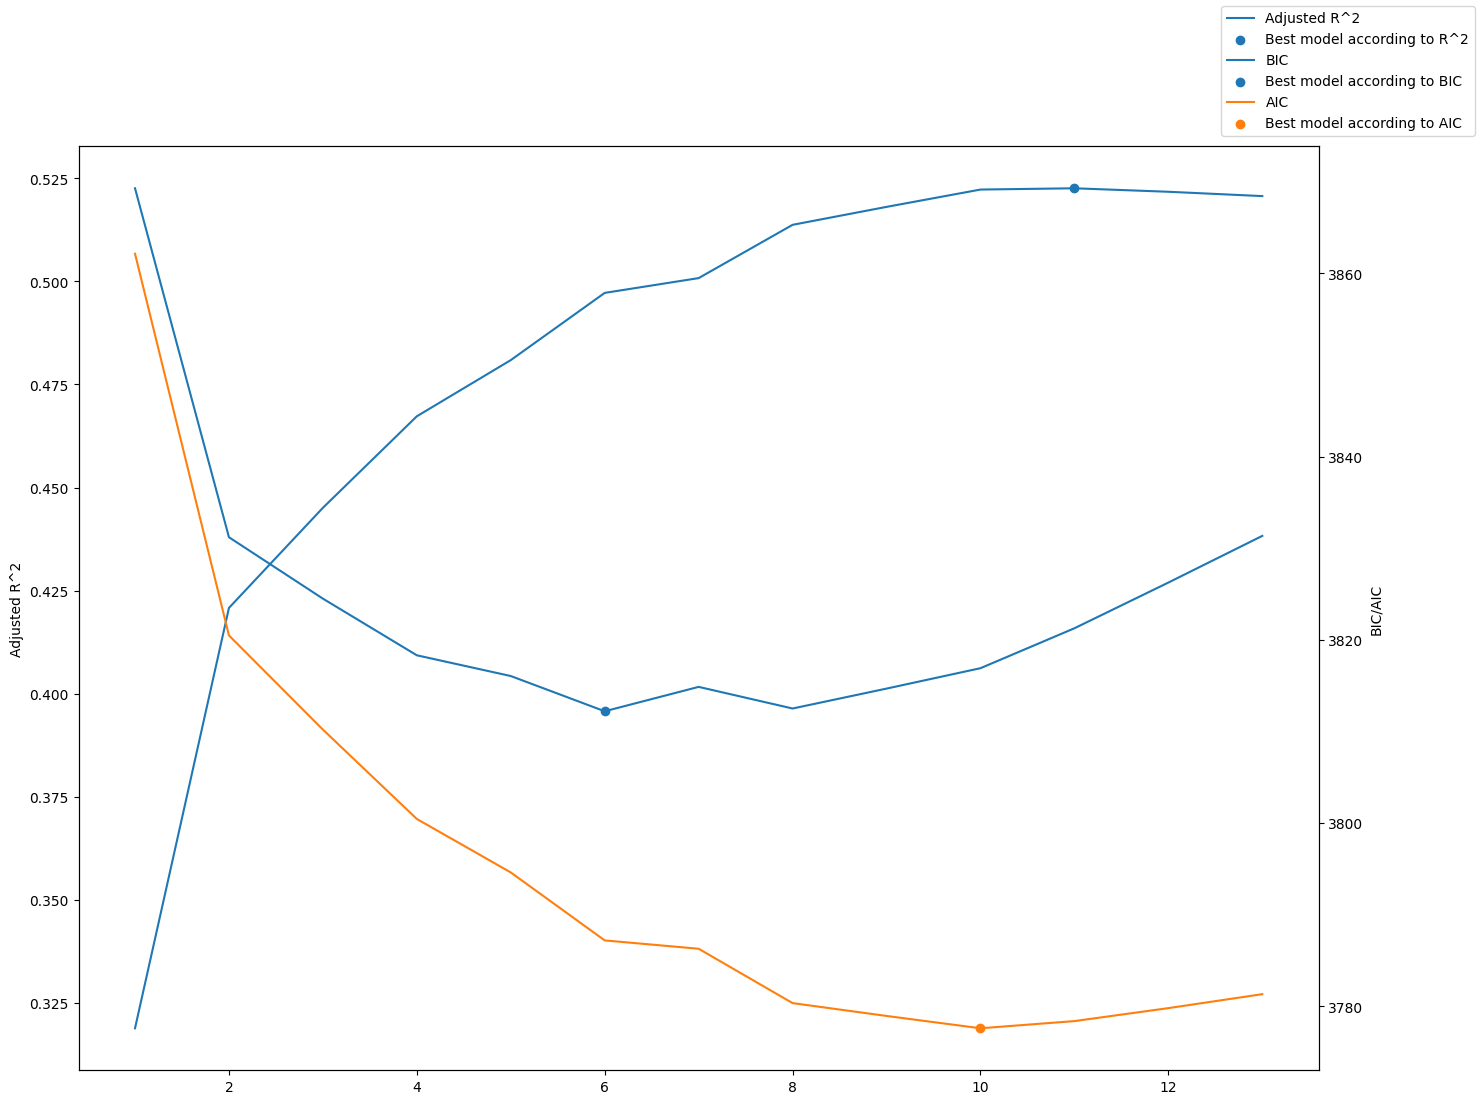

In [25]:
# we now plot the adjusted R^2, and BIC to find the best model across those with different predictor counts
fig, ax1 = plt.subplots(figsize = (16, 12))
rsquared_adj = models.apply(lambda row: row[1].rsquared_adj, axis=1)
ax1.plot(rsquared_adj, label = "Adjusted R^2")
ax1.scatter(np.argmax(rsquared_adj) + 1, max(rsquared_adj), label = "Best model according to R^2")
bic = models.apply(lambda row: row[1].bic, axis=1)
ax2 = ax1.twinx()
ax2.plot(bic, label = "BIC")
ax2.scatter(np.argmin(bic) + 1, min(bic), label = "Best model according to BIC")
aic = models.apply(lambda row: row[1].aic, axis=1)
ax2.plot(aic, label = "AIC")
ax2.scatter(np.argmin(aic) + 1, min(aic), label = "Best model according to AIC")
ax2.set_xlabel("Number of features")
ax1.set_ylabel("Adjusted R^2")
ax2.set_ylabel("BIC/AIC")
fig.legend()

### From the plot above we see that the best model is different depending on the statistic we use to determine it. For BIC we get the model with the least amount of predictors, namely $6$ in total.

In [29]:
# summary of best models
print("Best model according to BIC:")
print(models.loc[np.argmin(bic) + 1].Model.summary())
print("\nBest model according to AIC:")
print(models.loc[np.argmin(aic) + 1].Model.summary())
print("\nBest model according to adjusted R^2:")
print(models.loc[np.argmax(rsquared_adj) + 1].Model.summary())

Best model according to BIC:
                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.509
Model:                            OLS   Adj. R-squared:                  0.497
Method:                 Least Squares   F-statistic:                     44.18
Date:                Mon, 12 Sep 2022   Prob (F-statistic):           6.82e-37
Time:                        13:35:28   Log-Likelihood:                -1886.6
No. Observations:                 263   AIC:                             3787.
Df Residuals:                     256   BIC:                             3812.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -31.4397  

## 1.2 Forward and Backward Stepwise Selection
### We can also attempt to find the best model using a stepwise selection procedure. For forward selection we determine the best model with 1 predictor, then the best 2-variable model which preserves the originall chosen variable, and so on.

In [76]:
# define method which performs forward stepwise selection
def forward_step(y, X, feature_list):
    remaining_predictors = [p for p in X.columns if p not in feature_list]
    all_models = []
    min_RSS = None
    chosen_predictor = None
    for p in remaining_predictors:
        all_models.append(getRSS(y, X, feature_list+[p]))
        if min_RSS == None or min_RSS > all_models[-1]["RSS"]:
            min_RSS = all_models[-1]["RSS"]
            chosen_predictor = p

    all_models = pd.DataFrame(all_models)
    best_model = all_models.loc[all_models['RSS'].idxmin()]
    feature_list.append(chosen_predictor)
    return best_model

In [77]:
models_forward = pd.DataFrame(columns=['RSS', 'Model'])
feature_list = []

In [78]:
for no_features in range(1, len(X.columns) + 1):
    print("Finding best model using forward selection for " + str(no_features) + "/19 features...")
    models_forward.loc[no_features] = forward_step(y_data, X, feature_list)
    print("Best model found with R^2:", models_forward.loc[no_features].Model.rsquared)
    print("and adjusted R^2:", models_forward.loc[no_features].Model.rsquared_adj)
    print("\n")

Finding best model using forward selection for 1/19 features...
Best model found with R^2: 0.3214500886678948
and adjusted R^2: 0.31885028057849973


Finding best model using forward selection for 2/19 features...
Best model found with R^2: 0.42522374646677874
and adjusted R^2: 0.4208023906703694


Finding best model using forward selection for 3/19 features...
Best model found with R^2: 0.45142941571795725
and adjusted R^2: 0.44507531628611896


Finding best model using forward selection for 4/19 features...
Best model found with R^2: 0.47540665339478694
and adjusted R^2: 0.4672734232148611


Finding best model using forward selection for 5/19 features...
Best model found with R^2: 0.4908036159635182
and adjusted R^2: 0.4808970715270108


Finding best model using forward selection for 6/19 features...
Best model found with R^2: 0.5087145573589966
and adjusted R^2: 0.49720005479709806


Finding best model using forward selection for 7/19 features...
Best model found with R^2: 0.5132286

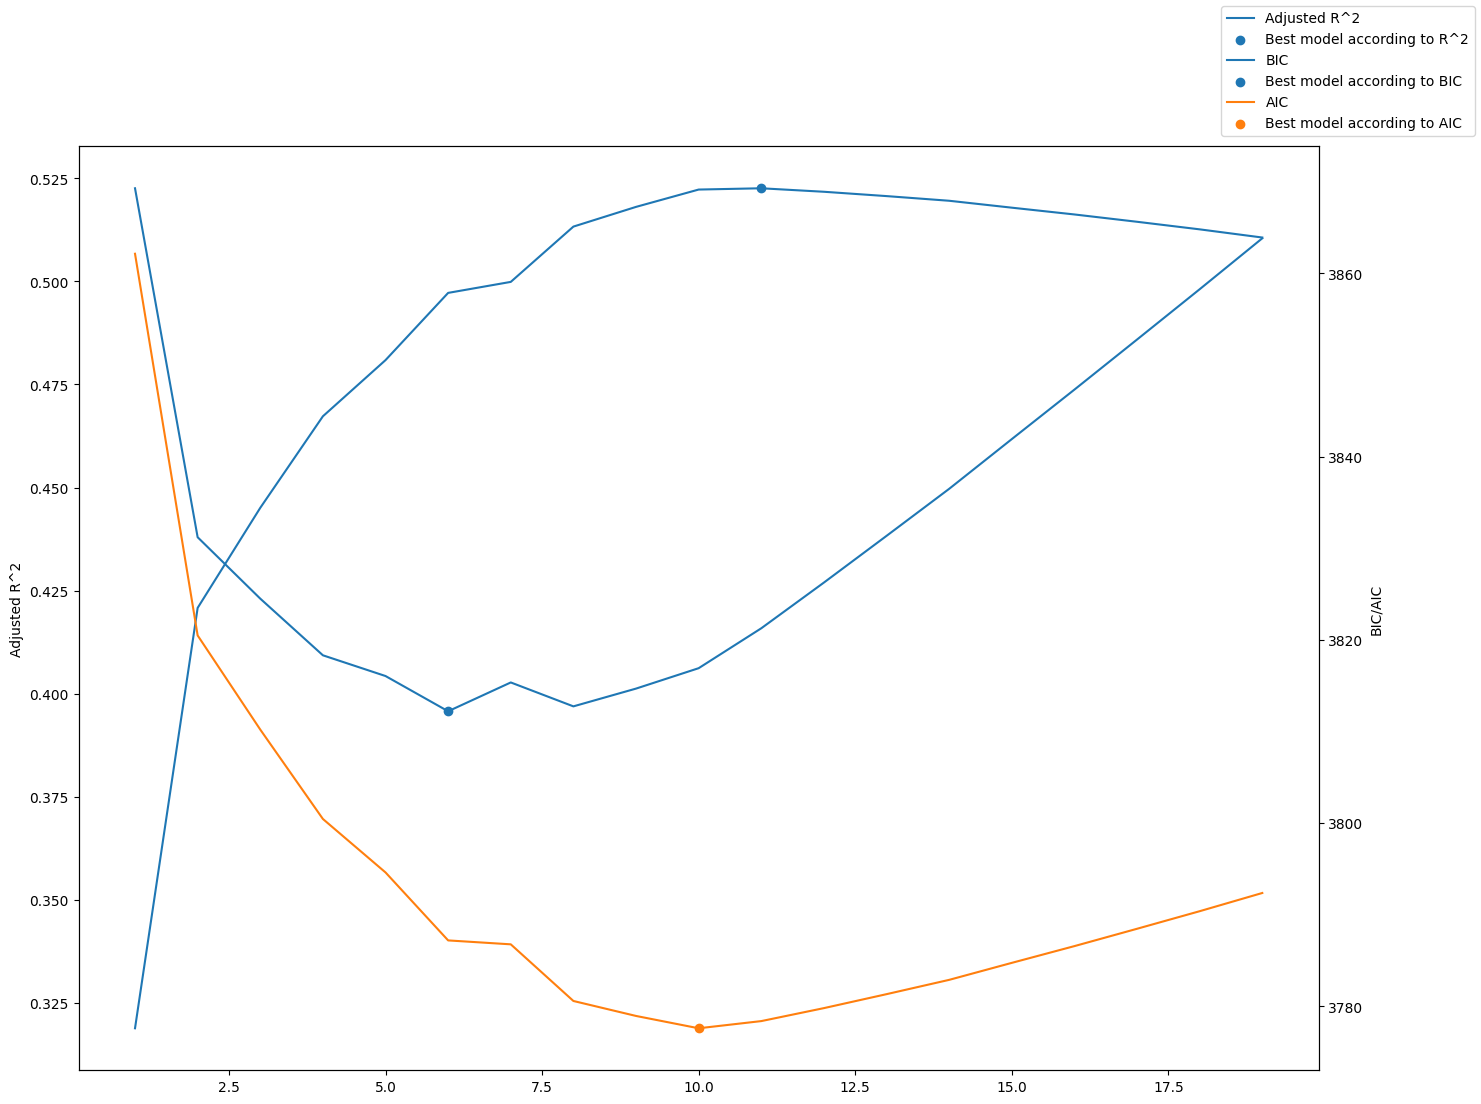

In [79]:
# we now plot the adjusted R^2, and BIC to find the best model across those with different predictor counts
fig, ax1 = plt.subplots(figsize = (16, 12))
rsquared_adj = models_forward.apply(lambda row: row[1].rsquared_adj, axis=1)
ax1.plot(rsquared_adj, label = "Adjusted R^2")
ax1.scatter(np.argmax(rsquared_adj) + 1, max(rsquared_adj), label = "Best model according to R^2")
bic = models_forward.apply(lambda row: row[1].bic, axis=1)
ax2 = ax1.twinx()
ax2.plot(bic, label = "BIC")
ax2.scatter(np.argmin(bic) + 1, min(bic), label = "Best model according to BIC")
aic = models_forward.apply(lambda row: row[1].aic, axis=1)
ax2.plot(aic, label = "AIC")
ax2.scatter(np.argmin(aic) + 1, min(aic), label = "Best model according to AIC")
ax2.set_xlabel("Number of features")
ax1.set_ylabel("Adjusted R^2")
ax2.set_ylabel("BIC/AIC")
fig.legend()

In [81]:
# summary of best models
print("Best model according to BIC:")
print(models_forward.loc[np.argmin(bic) + 1].Model.summary())
print("\nBest model according to AIC:")
print(models_forward.loc[np.argmin(aic) + 1].Model.summary())
print("\nBest model according to adjusted R^2:")
print(models_forward.loc[np.argmax(rsquared_adj) + 1].Model.summary())

Best model according to BIC:
                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.509
Model:                            OLS   Adj. R-squared:                  0.497
Method:                 Least Squares   F-statistic:                     44.18
Date:                Mon, 12 Sep 2022   Prob (F-statistic):           6.82e-37
Time:                        13:57:15   Log-Likelihood:                -1886.6
No. Observations:                 263   AIC:                             3787.
Df Residuals:                     256   BIC:                             3812.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -31.4397  

### From the results above we see that forward selection chooses the same number of predictors as best subset selection. However, the former is much quicker in terms of time complexity, and so is likely preferable.
### We can also perform backward selection, where we start from a model with all predictors, determine which one contributes the least, and remove it from the set. Specifically, we find the model with the lowest RSS from this with one less features, and so on.

In [125]:
def backward_step(y, X, feature_list):
    all_models = []
    chosen_predictor = None
    for combo in itertools.combinations(feature_list, len(feature_list) - 1):
        all_models.append(getRSS(y, X, combo))
    all_models = pd.DataFrame(all_models)
    best_model = all_models.loc[all_models['RSS'].idxmin()]
    return best_model

In [126]:
models_backward = pd.DataFrame(columns=["RSS", "Model"], index = range(1, len(X.columns) + 1))
feature_list = X.columns
models_backward.loc[len(feature_list)] = getRSS(y_data, X, feature_list)

while len(feature_list) > 1:
    models_backward.loc[len(feature_list) - 1] = backward_step(y_data, X, feature_list)
    feature_list = models_backward.loc[len(feature_list) - 1]["Model"].model.exog_names.copy()
    feature_list.remove('const')

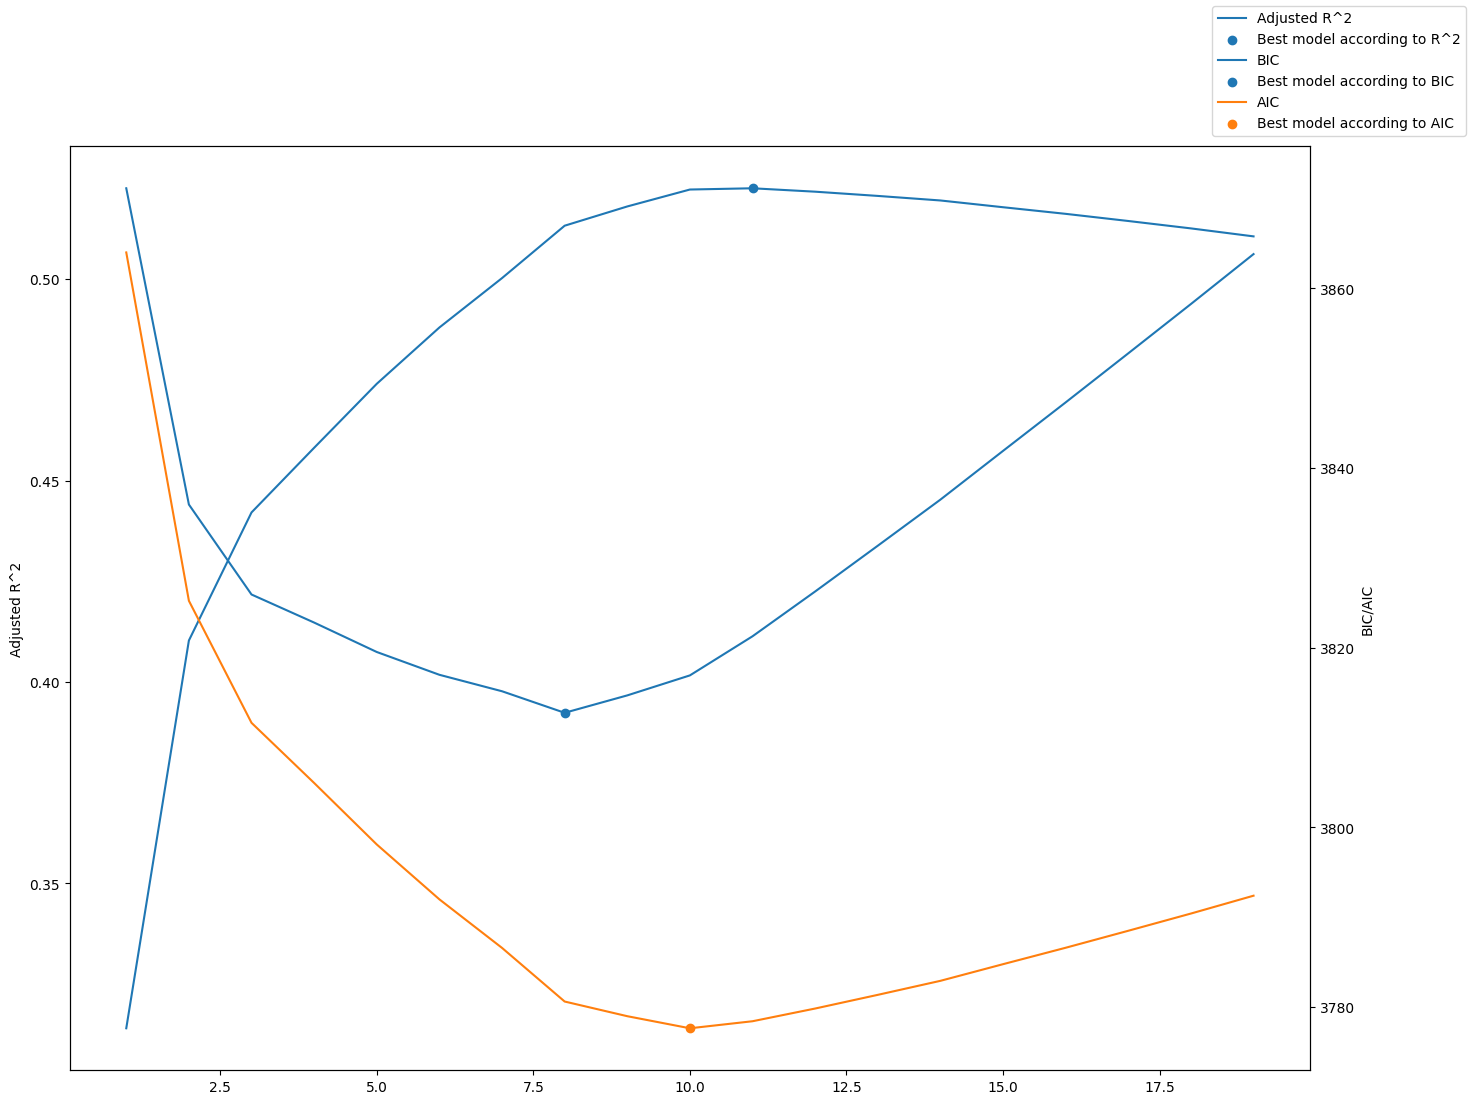

In [127]:
# we now plot the adjusted R^2, and BIC to find the best model across those with different predictor counts
fig, ax1 = plt.subplots(figsize = (16, 12))
rsquared_adj = models_backward.apply(lambda row: row[1].rsquared_adj, axis=1)
ax1.plot(rsquared_adj, label = "Adjusted R^2")
ax1.scatter(np.argmax(rsquared_adj) + 1, max(rsquared_adj), label = "Best model according to R^2")
bic = models_backward.apply(lambda row: row[1].bic, axis=1)
ax2 = ax1.twinx()
ax2.plot(bic, label = "BIC")
ax2.scatter(np.argmin(bic) + 1, min(bic), label = "Best model according to BIC")
aic = models_backward.apply(lambda row: row[1].aic, axis=1)
ax2.plot(aic, label = "AIC")
ax2.scatter(np.argmin(aic) + 1, min(aic), label = "Best model according to AIC")
ax2.set_xlabel("Number of features")
ax1.set_ylabel("Adjusted R^2")
ax2.set_ylabel("BIC/AIC")
fig.legend()

In [129]:
# summary of best models
print("Best model according to BIC:")
print(models_backward.loc[np.argmin(bic) + 1].Model.summary())
print("\nBest model according to AIC:")
print(models_backward.loc[np.argmin(aic) + 1].Model.summary())
print("\nBest model according to adjusted R^2:")
print(models_backward.loc[np.argmax(rsquared_adj) + 1].Model.summary())

Best model according to BIC:
                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.528
Model:                            OLS   Adj. R-squared:                  0.513
Method:                 Least Squares   F-statistic:                     35.54
Date:                Mon, 12 Sep 2022   Prob (F-statistic):           2.02e-37
Time:                        14:32:03   Log-Likelihood:                -1881.3
No. Observations:                 263   AIC:                             3781.
Df Residuals:                     254   BIC:                             3813.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.6278  

### For backward selection we see that the optimal number of predictors is once again the same, except when using BIC. Then we get a count of $8$ variables rather than $6$ as for forward selection and best subset. Nonetheless, the set of $6$ variables is contained in the $8$-feature one found by backward selection.
## 1.3 Choosing Among Models Using the Validation Set Approach and Cross-Validation
### Another approach to determine the best feature subsets is to use validation test data sets instead of the $R^2$, BIC and AIC statistics. As a start, we split the full data set randomly into a training set with roughly $70\%$ of the entries, and a test set.

In [165]:
np.random.seed(seed=21)
train_index = np.random.choice([True, False], size=len(y_data), replace=True, p=[0.7, 0.3])
test_index = np.invert(train_index)
X_train = X[train_index]
y_train = y_data[train_index]
X_test = X[test_index]
y_test = y_data[test_index]

In [166]:
# we will use slightly modified versions of the previously defined methods
def getRSS_validation(y_train, X_train, y_test, X_test, feature_list):
    """
    Fit a model for a given subset of features in X, determined by feature_list, and record the RSS on the training data.
    """
    model = sm.OLS(y_train, sm.add_constant(X_train[list(feature_list)])).fit()
    RSS = ((model.predict(sm.add_constant(X_test[list(feature_list)])) - y_test)**2).sum()
    return {'Model': model, "RSS": RSS}

def forward_step_validation(y_train, X_train, y_test, X_test, feature_list):
    remaining_predictors = [p for p in X_train.columns if p not in feature_list]
    all_models = []
    min_RSS = None
    chosen_predictor = None
    for p in remaining_predictors:
        all_models.append(getRSS_validation(y_train, X_train, y_test, X_test, feature_list+[p]))
        if min_RSS == None or min_RSS > all_models[-1]["RSS"]:
            min_RSS = all_models[-1]["RSS"]
            chosen_predictor = p

    all_models = pd.DataFrame(all_models)
    best_model = all_models.loc[all_models['RSS'].idxmin()]
    feature_list.append(chosen_predictor)
    return best_model

def backward_step_validation(y_train, X_train, y_test, X_test, feature_list):
    all_models = []
    chosen_predictor = None
    for combo in itertools.combinations(feature_list, len(feature_list) - 1):
        all_models.append(getRSS_validation(y_train, X_train, y_test, X_test, combo))
    all_models = pd.DataFrame(all_models)
    best_model = all_models.loc[all_models['RSS'].idxmin()]
    return best_model

In [167]:
# perform forward and backward selection
models_forward_validation = pd.DataFrame(columns=["RSS", "Model"])
feature_list = []
for no_features in range(1, len(X_train.columns)+1):
    models_forward_validation.loc[no_features] = forward_step_validation(y_train, X_train, y_test, X_test, feature_list)

models_backward_validation = pd.DataFrame(columns=["RSS", "Model"], index = range(1, len(X.columns) + 1))
feature_list = X.columns
models_backward_validation.loc[len(feature_list)] = getRSS_validation(y_train, X_train, y_test, X_test, feature_list)

while len(feature_list) > 1:
    models_backward_validation.loc[len(feature_list) - 1] = backward_step_validation(y_train, X_train, y_test, X_test, feature_list)
    feature_list = models_backward_validation.loc[len(feature_list) - 1]["Model"].model.exog_names.copy()
    feature_list.remove('const')


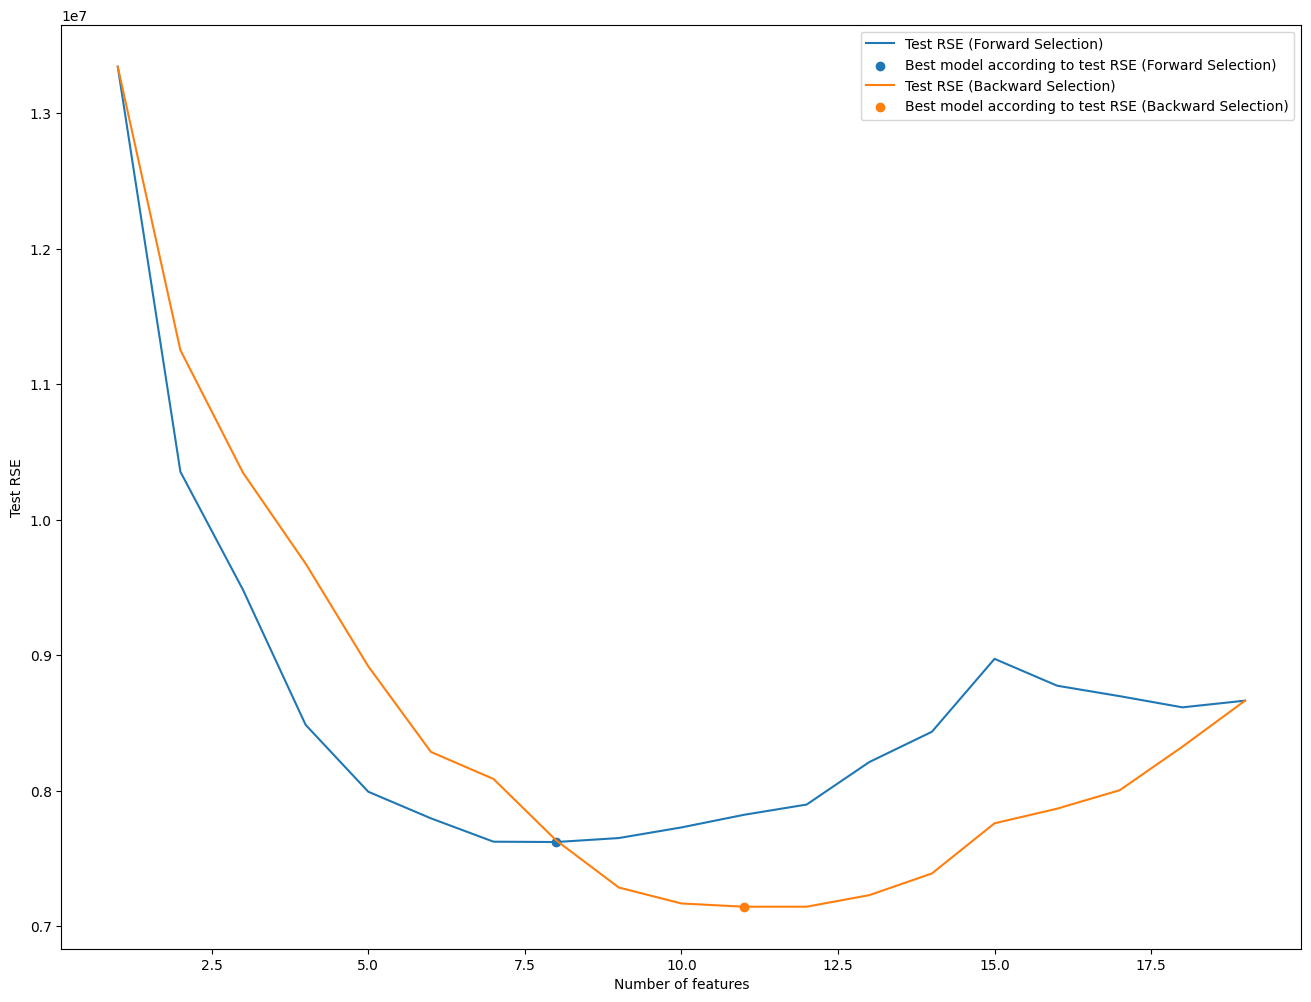

In [168]:
# plot the results
fig, ax1 = plt.subplots(1, 1, figsize = (16, 12))
rse = models_forward_validation.apply(lambda row: row[0], axis=1)
ax1.plot(rse, label = "Test RSE (Forward Selection)")
ax1.scatter(np.argmin(rse) + 1, min(rse), label = "Best model according to test RSE (Forward Selection)")
rse = models_backward_validation.apply(lambda row: row[0], axis=1)
ax1.plot(rse, label = "Test RSE (Backward Selection)")
ax1.scatter(np.argmin(rse) + 1, min(rse), label = "Best model according to test RSE (Backward Selection)")
ax1.set_xlabel("Number of features")
ax1.set_ylabel("Test RSE")
ax1.legend()

### From the plot above we see that the optimal number of features when using a validation test set is similar to the number found using the original approach. However, the results vary depending on the train-test split we use for the data set. Hence, a better approach would be to use cross-validation, where we split the full data set into $K$, say $K=10$, subsets, train $K$ models using each of the $K$ subsets as the test data set.

In [181]:
K = 10
np.random.seed(seed=2111)
train_index = np.random.choice(K, size = len(y_data), replace=True)
cv_RSEs_forward = pd.DataFrame(columns=range(1, K+1), index=range(1, len(X.columns) + 1)) # data frame containing K models for each number of features
cv_RSEs_backward = pd.DataFrame(columns=range(1, K+1), index=range(1, len(X.columns) + 1)) # data frame containing K models for each number of features

In [182]:
models_cv_forward = pd.DataFrame(columns=["RSS", "Model"])
for subset in range(1, K+1):
    feature_list = []
    for no_features in range(1, len(X.columns) + 1):
        models_cv_forward.loc[no_features] = forward_step_validation(y_data[train_index != (subset - 1)], X[train_index != (subset - 1)], y_data[train_index == (subset - 1)], X[train_index == (subset - 1)], feature_list)
        cv_RSEs_forward[subset][no_features] = models_cv_forward.loc[no_features]["RSS"]

models_cv_backward = pd.DataFrame(columns=["RSS", "Model"], index=range(1, len(X.columns) + 1))
for subset in range(1, K+1):
    feature_list = X.columns
    models_cv_backward.loc[len(feature_list)] = getRSS_validation(y_data[train_index != (subset - 1)], X[train_index != (subset - 1)], y_data[train_index == (subset - 1)], X[train_index == (subset - 1)], feature_list)
    cv_RSEs_backward[subset][len(feature_list)] = models_cv_forward.loc[len(feature_list) - 1]["RSS"]
    while len(feature_list) > 1:
        models_cv_backward.loc[len(feature_list)-1] = backward_step_validation(y_data[train_index != (subset - 1)], X[train_index != (subset - 1)], y_data[train_index == (subset - 1)], X[train_index == (subset - 1)], feature_list)
        cv_RSEs_backward[subset][len(feature_list) - 1] = models_cv_forward.loc[len(feature_list) - 1]["RSS"]
        feature_list = models_cv_backward.loc[len(feature_list) - 1]["Model"].model.exog_names.copy()
        feature_list.remove('const')
        

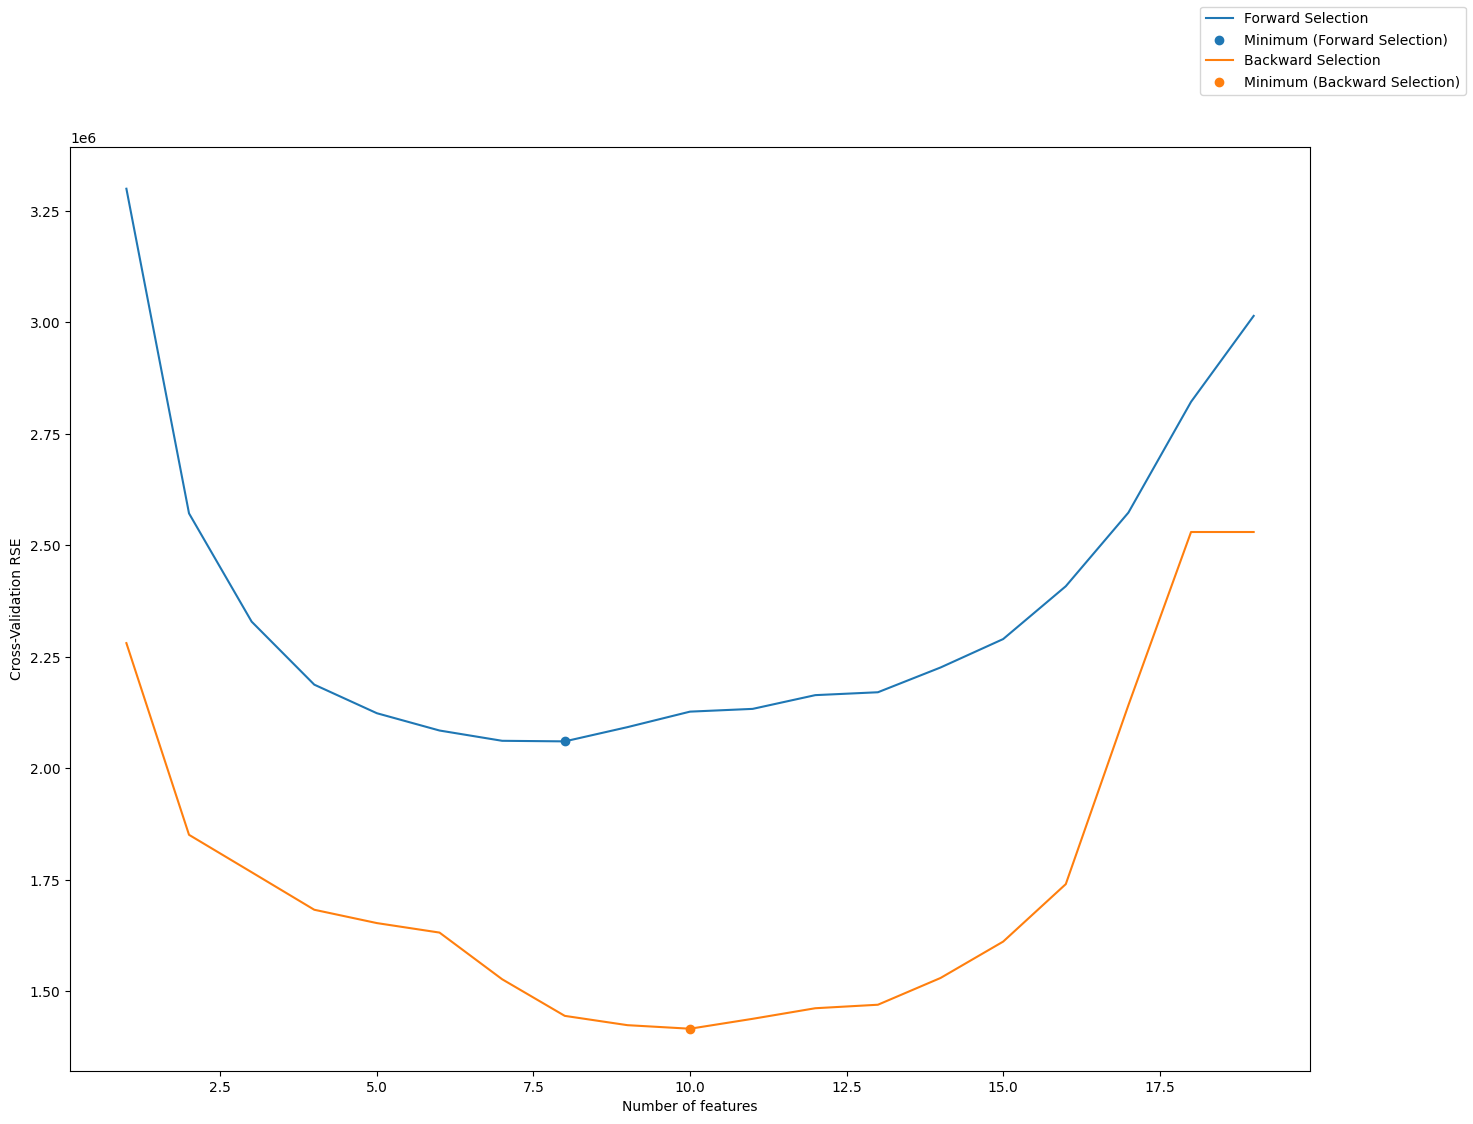

In [183]:
# plot the mean RSE for each feature count
fig_cv, ax_cv = plt.subplots(figsize = (16, 12))
cv_RSEs_mean = cv_RSEs_forward.mean(axis=1)
ax_cv.plot(cv_RSEs_mean, label = "Forward Selection")
ax_cv.scatter(np.argmin(cv_RSEs_mean) + 1, min(cv_RSEs_mean), label = "Minimum (Forward Selection)")
cv_RSEs_mean = cv_RSEs_backward.mean(axis=1)
ax_cv.plot(cv_RSEs_mean, label = "Backward Selection")
ax_cv.scatter(np.argmin(cv_RSEs_mean) + 1, min(cv_RSEs_mean), label = "Minimum (Backward Selection)")
ax_cv.set_xlabel("Number of features")
ax_cv.set_ylabel("Cross-Validation RSE")
fig_cv.legend()

## 2. Ridge Regression and the Lasso
### We now consider the two regularisation methods - ridge and lasso regression. In these cases the minimisation problem when fitting the model contains an additional term which has the effect of shrinking the estimated coeeficients toward zero. In ridge regression we constrain the $l2$-norm of the coefficient vector to have a fixed value, whereas in lasso regression the constrain is on the $l1$-norm. Effectively, this allows lasso regression to set some of the coefficients to zero, thereby performing feature selection as well.

In [191]:
Hitters = pd.read_csv("Hitters.csv", header=0, na_values='NA')
Hitters = Hitters.dropna().reset_index(drop=True)
y_data = Hitters.Salary
dummy_predictors = pd.get_dummies(Hitters[['League', 'Division', 'NewLeague']])
X = pd.concat([Hitters.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64'), dummy_predictors[['League_A', 'Division_E', 'NewLeague_A']]], axis=1)

In [224]:
# define the regularisation parameters
lambdas = 10 ** np.linspace(5, -2, 100)

In [225]:
ridge = Ridge(fit_intercept=True, normalize=True)
coefficients = []
intercepts = []
for l in lambdas:
    ridge.set_params(alpha=l)
    ridge.fit(X, y_data)
    coefficients.append(ridge.coef_)
    intercepts.append(ridge.intercept_)

/Users/nikolayanakiev/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(
/Users/nikolayanakiev/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. T

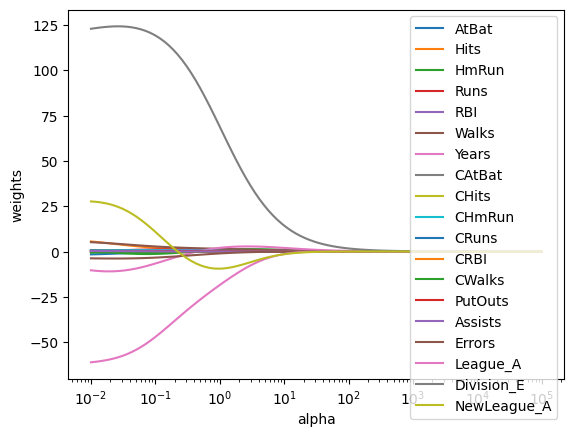

In [226]:
# plot the results
ax = plt.gca()
ax.plot(lambdas, coefficients)
ax.set_xscale('log') 
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.legend(X.columns)
plt.show()

In [227]:
# to determine the best regularisation parameter we use cross-validation
X_train, X_test, y_train, y_test = train_test_split(X, y_data, test_size=2/3)

In [228]:
ridge_CV = RidgeCV(lambdas, scoring='neg_mean_squared_error', normalize=True)
ridge_CV.fit(X_train, y_train)
print(ridge_CV.alpha_)

0.6892612104349695


/Users/nikolayanakiev/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), _RidgeGCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alphas to: original_alphas * n_samples. 
  warnings.warn(


In [230]:
# fit model with best lambda
ridge_best = Ridge(alpha=ridge_CV.alpha_, normalize=True)
ridge_best.fit(X_train, y_train)
print(mean_squared_error(y_test, ridge_best.predict(X_test)))
coefficients_series = pd.Series(ridge_best.coef_, index=X.columns)
coefficients_series = coefficients_series.reindex(coefficients_series.abs().sort_values(ascending=False).index)
print(coefficients_series)

121614.22998946058
Division_E     81.947164
League_A      -29.522014
NewLeague_A    -4.961247
Years           3.441162
Errors         -3.004547
Runs            2.101286
Walks           2.080934
HmRun           1.803480
Hits            1.118789
CHmRun          0.562703
RBI             0.375883
CWalks          0.199288
PutOuts         0.158346
CRuns           0.139563
AtBat           0.133268
CRBI            0.090433
CHits           0.047621
Assists        -0.024469
CAtBat          0.007929
dtype: float64


/Users/nikolayanakiev/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(


### We consider now the Lasso regression.

/Users/nikolayanakiev/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
/Users/nikolayanakiev/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing

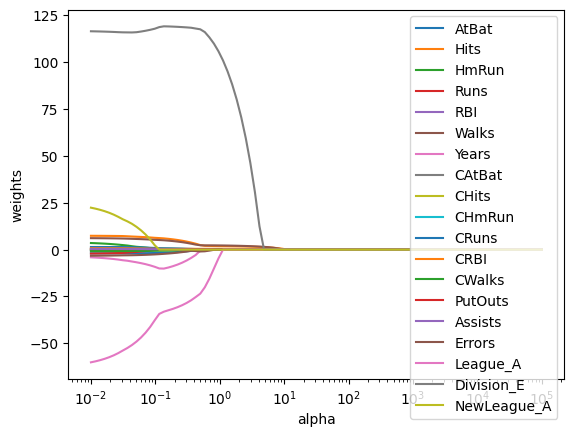

In [231]:
lasso = Lasso(normalize=True, max_iter=int(1e5))
coefficients = []
for l in lambdas:
    lasso.set_params(alpha = l)
    lasso.fit(X, y_data)
    coefficients.append(lasso.coef_)

ax = plt.gca()
ax.plot(lambdas, coefficients)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.legend(X.columns)
plt.show()

In [232]:
# determine the best lasso model using cross-validation
lasso_CV = LassoCV(alphas=None, cv=10, max_iter=int(1e5), normalize=True)
lasso_CV.fit(X_train, y_train)
lasso.set_params(alpha=lasso_CV.alpha_)
lasso.fit(X_train, y_train)
print(mean_squared_error(y_test, lasso.predict(X_test)))
coefficients_series = pd.Series(lasso.coef_, index=X.columns)
coefficients_series = coefficients_series.reindex(coefficients_series.abs().sort_values(ascending=False).index)
print(coefficients_series)

129025.27424994354
Division_E     95.048804
League_A      -23.977317
Errors         -4.789408
Hits            3.329042
Runs            2.504673
CHmRun          1.431514
Walks           1.394819
RBI            -1.048440
CWalks          0.377692
PutOuts         0.258125
AtBat          -0.214522
CRuns           0.175099
CRBI            0.000000
CHits           0.000000
Assists        -0.000000
CAtBat         -0.000000
Years           0.000000
HmRun           0.000000
NewLeague_A    -0.000000
dtype: float64


/Users/nikolayanakiev/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
/Users/nikolayanakiev/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing

## 3. PCA and PLS Regression
### As a final regularisation technique we consider two approaches of dimensionality reduction - PCA and PLS.
### 3.1 Principal Component Analysis (PCA)

In [234]:
Hitters = pd.read_csv("Hitters.csv", header=0, na_values='NA')
Hitters = Hitters.dropna().reset_index(drop=True)
y_data = Hitters.Salary
dummy_predictors = pd.get_dummies(Hitters[['League', 'Division', 'NewLeague']])
X = pd.concat([Hitters.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1).astype('float64'), dummy_predictors[['League_A', 'Division_E', 'NewLeague_A']]], axis=1)

In [235]:
# define method which perform PCA regression for given number of PCA components
def pcr(X, y, PCs):
    pca = PCA()
    X_pca = pca.fit_transform(scale(X))[:, :PCs]

    regr = linear_model.LinearRegression()

    y_cv = cross_val_predict(regr, X_pca, y, cv=20)

    score_cv = r2_score(y, y_cv)

    mse_cv = mean_squared_error(y, y_cv)

    return (score_cv, mse_cv)

Text(0, 0.5, 'Cross-Validation MSE')

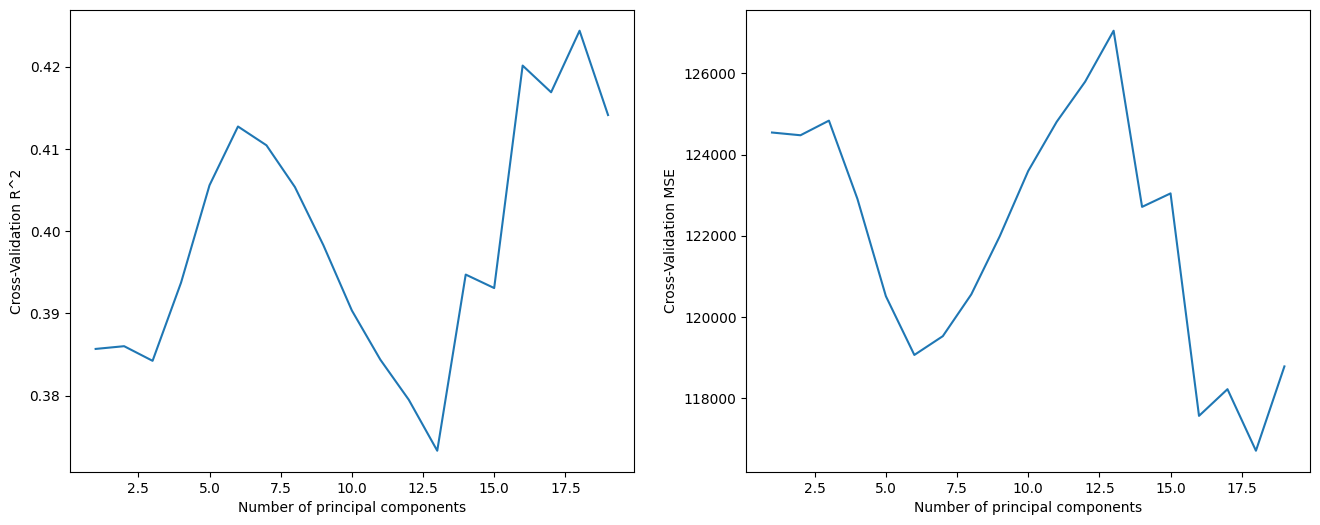

In [236]:
mse_cv = []
scores_cv = []

for no_components in range(1, len(X.columns)+1):
    results = pcr(X, y_data, no_components)
    scores_cv.append(results[0])
    mse_cv.append(results[1])

# plot the results
fig_pcr, (ax_pcr_1, ax_pcr_2) = plt.subplots(1, 2, figsize = (16, 6))
ax_pcr_1.plot(range(1, len(X.columns)+1), scores_cv)
ax_pcr_1.set_xlabel("Number of principal components")
ax_pcr_1.set_ylabel("Cross-Validation R^2")
ax_pcr_2.plot(range(1, len(X.columns)+1), mse_cv)
ax_pcr_2.set_xlabel("Number of principal components")
ax_pcr_2.set_ylabel("Cross-Validation MSE")

### From the analysis above it seems that the optimal number of components to use is $6.$ Generally, PLS leads to no significant imporvement over PCR, so I have left it out for now.